# Importing libraries and loading data

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [44]:
# Load the dataset
current_path = os.getcwd()
parent_folder = os.path.dirname(current_path)
data_file_path = os.path.join(parent_folder, "Data", "005930.KS.csv") # import weekly data

df = pd.read_csv(str(data_file_path))

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# Checking duplicates and empty entries

In [45]:
df = df[~df.index.duplicated()]

In [46]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [47]:
df.dropna(inplace=True)


# Data Analysis


Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1505 entries, 2019-01-02 to 2025-02-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1505 non-null   float64
 1   High       1505 non-null   float64
 2   Low        1505 non-null   float64
 3   Close      1505 non-null   float64
 4   Adj Close  1505 non-null   float64
 5   Volume     1505 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 114.6 KB
None

Data Description:
               Open          High           Low         Close     Adj Close  \
count   1505.000000   1505.000000   1505.000000   1505.000000   1505.000000   
mean   64154.617940  64734.019934  63548.704319  64108.903654  59933.013632   
std    12269.830763  12321.091699  12176.813372  12227.346773  12894.680103   
min    37450.000000  37600.000000  36850.000000  37450.000000  31952.667969   
25%    54700.000000  55500.000000  54200.000000  54900.000000  50596.2656

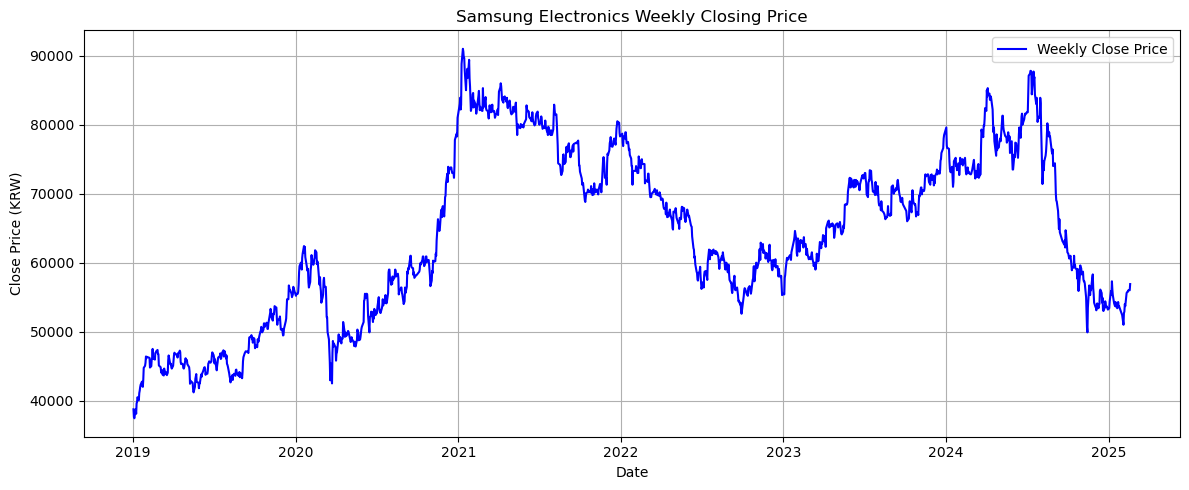

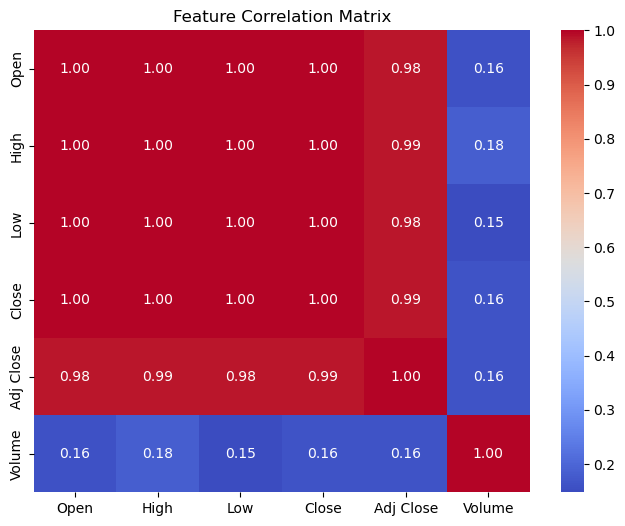

In [ ]:
print("\nData Info:")  # viewing data info
print(df.info())
print("\nData Description:")
print(df.describe())

# close price
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Daily Close Price', color='blue')
plt.title('Samsung Electronics Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Corr heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()


# Feature Engineering, defining features and targets, training testing split, training and saving model

Loop to create multiple trained models for deployment later, not pretty but it is what it is

In [49]:
for weeks_ahead in range(1, 5):
    print(f"Training model for {weeks_ahead} week(s) ahead...")

    days_ahead = weeks_ahead * 5
    df_feat = df.copy()

 
    window_short = 3 * days_ahead
    window_long = 5 * days_ahead

    df_feat['Close_ma3'] = df_feat['Close'].rolling(window_short).mean()
    df_feat['Close_ma5'] = df_feat['Close'].rolling(window_long).mean()
    df_feat['Volume_ma3'] = df_feat['Volume'].rolling(window_short).mean()
    df_feat['Volume_ma5'] = df_feat['Volume'].rolling(window_long).mean()
    df_feat['Close_std3'] = df_feat['Close'].rolling(window_short).std()
    df_feat['Close_std5'] = df_feat['Close'].rolling(window_long).std()

    df_feat['Return_1w'] = df_feat['Close'].pct_change(5)  # 1 week
    df_feat['Return_3w'] = df_feat['Close'].pct_change(15) # 3 weeks

    # 1 if price goes up after X days, else 0
    df_feat['Target'] = (df_feat['Close'].shift(-days_ahead) > df_feat['Close']).astype(int)

    # Drop rows with NaNs
    df_feat = df_feat.dropna()

    # Define features and target
    feature_cols = [
        'Close_ma3', 'Close_ma5',
        'Volume_ma3', 'Volume_ma5',
        'Close_std3', 'Close_std5',
        'Return_1w', 'Return_3w',
        'Close', 'Open', 'High', 'Low'
    ]
    X = df_feat[feature_cols]
    y = df_feat['Target']


    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    # Model training
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Save model for deployment
    model_filename = f"../artifact/model_{weeks_ahead}w.pkl"
    joblib.dump(model, model_filename)
    print(f"Saved: {model_filename}\n")

    # Evaluate
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Training model for 1 week(s) ahead...
Saved: ../artifact/model_1w.pkl

[[ 60 108]
 [ 31  98]]
              precision    recall  f1-score   support

           0       0.66      0.36      0.46       168
           1       0.48      0.76      0.59       129

    accuracy                           0.53       297
   macro avg       0.57      0.56      0.52       297
weighted avg       0.58      0.53      0.52       297

Training model for 2 week(s) ahead...
Saved: ../artifact/model_2w.pkl

[[ 61 107]
 [ 54  70]]
              precision    recall  f1-score   support

           0       0.53      0.36      0.43       168
           1       0.40      0.56      0.47       124

    accuracy                           0.45       292
   macro avg       0.46      0.46      0.45       292
weighted avg       0.47      0.45      0.45       292

Training model for 3 week(s) ahead...
Saved: ../artifact/model_3w.pkl

[[ 61 123]
 [ 40  63]]
              precision    recall  f1-score   support

         

# More data evaluation

In [50]:
print(df_feat['Target'].value_counts(normalize=True))

Target
1    0.504979
0    0.495021
Name: proportion, dtype: float64


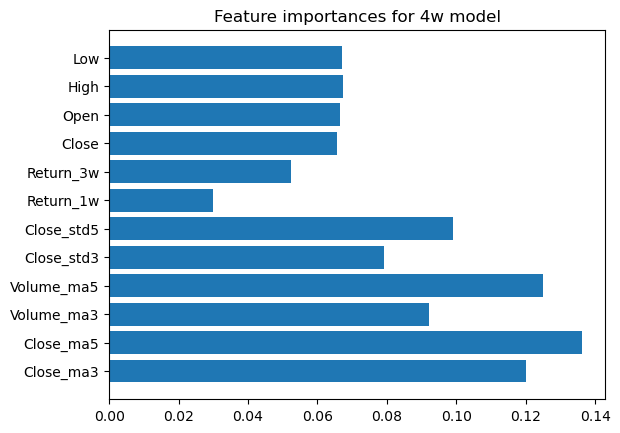

In [51]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
plt.barh(feature_cols, importances)
plt.title(f"Feature importances for {weeks_ahead}w model")
plt.show()